In [1]:
import os
os.chdir(".")

from model import CNN_Model, LSTM_Model_RUL, CNN_Model_RUL, Net, Net_new, Autoencoder, LSTM_Model
from load_data import get_data, get_data_RUL_scenario1, get_discharge_capacities_MIT,get_discharge_capacities_HUST, get_dirs, get_data_RUL_scenario2
from dataloader import  battery_dataloader, battery_dataloader_RUL, get_RUL_dataloader
from import_file import *
from train_model import train_model, train_model_RUL, test_model_RUL, perform_n_folds
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from util_FPC import get_fpc_window, get_data, get_fpc, get_change_indices, EarlyStopping, plot_RUL, weight_reset

/home/dmittal/.conda/envs/RUL_Prediction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-15 15:54:01.452789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
percentage  = 0.10  # 10 percent data
window_size = 50    # window size
stride = 1          # stride
channels_MIT  =[0,1,2,3,4,5,6] # channels MIT
channels_HUST  =[0]           # channels HUST

name_start_train_MIT = 0
name_start_test_MIT = 100

name_start_train_HUST = 0
name_start_test_HUST = 70

version = 1

discharge_capacities_MIT = get_discharge_capacities_MIT()
discharge_capacities_HUST = get_discharge_capacities_HUST(fea_num=1)

ch_MIT = ''.join(map(str,channels_MIT))
ch_HUST  = ''.join(map(str,channels_HUST))

# model = CNN_Model(window_size,len(channels))
model_MIT = LSTM_Model(window_size,len(channels_MIT))
model_HUST = LSTM_Model(window_size,len(channels_HUST))

model_dir = "./Weights/FPC/"
model_path_MIT = f'{model_dir}/{"MIT"}_{model_MIT.name}_FPC_Channels={ch_MIT}_WindowSize={window_size}_Version={version}.pth'
model_path_HUST = f'{model_dir}/{"HUST"}_{model_HUST.name}_FPC_Channels={ch_HUST}_WindowSize={window_size}_Version={version}.pth'
# model_path_MIT = r"C:\Users\Dhruv\OneDrive\Desktop\MIT_LSTM_Classifier_FPC_Channels=0123456_WindowSize=50_Version=1.pth"


model_MIT.load_state_dict(torch.load(model_path_MIT, map_location=device ))
model_HUST.load_state_dict(torch.load(model_path_HUST, map_location=device ))

change_indices_train_MIT,change_indices_test_MIT, _, _ = get_change_indices(model_MIT,discharge_capacities_MIT,channels_MIT,get_saved_indices = True, version = 1, name_start_train = name_start_train_MIT,name_start_test= name_start_test_MIT , dataset= "MIT") 
change_indices_all_MIT = np.concatenate((change_indices_train_MIT,change_indices_test_MIT))

change_indices_train_HUST,change_indices_test_HUST, _, _ = get_change_indices(model_HUST,discharge_capacities_HUST,channels_HUST,get_saved_indices = True, version = 1, name_start_train = name_start_train_HUST,name_start_test= name_start_test_HUST , dataset= "HUST") 
change_indices_all_HUST = np.concatenate((change_indices_train_HUST,change_indices_test_HUST))





Loading Old Indices
Mean FPC for Training is 94.70397282880278 and Test is 94.34361675432244
Loading Old Indices
Mean FPC for Training is 90.7711094783737 and Test is 86.69627199802251


In [3]:
model_path_MIT

'./Weights/FPC//MIT_LSTM_Classifier_FPC_Channels=0123456_WindowSize=50_Version=1.pth'

In [4]:
os.path.abspath(model_path_MIT)


'/home/dmittal/Desktop/RUL_Prediction_DFKI/FPC_Prediction/Weights/FPC/MIT_LSTM_Classifier_FPC_Channels=0123456_WindowSize=50_Version=1.pth'

In [5]:
def get_fpc_modified(model,batteries,discharge_capacities,data_loader,plot,show_FPC_curve,add_initial,save_path):
    
    plt.figure()
    if(plot):
        rows = len(batteries)
        col  = 1
        if(len(batteries)>1):
            fig, ax = plt.subplots(rows,col,figsize=(14,8*len(batteries)),sharex=True, sharey=True)
            ax = ax.flatten()
        else:
            fig, ax = plt.subplots(rows,col,figsize=(14,10),sharex=True, sharey=True)
            
        
        # plt.suptitle("FPC Prediction", fontsize = 20)
        # fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    
    change_percentage = []
    change_indices    = []
    model.eval()
    preds = []
    
    
    for ind,battery in enumerate(batteries):

        pred = []
        battery_name = "battery"+ str(battery)
        for x in data_loader[battery_name]:
            x = x.view(1,x.shape[0],x.shape[1])
            x = x.to(device=device)
            out = torch.where(model(x) > 0.5, 1, 0) 
            pred.append(out.cpu().detach().numpy()[0][0].astype(float))

        index,smoothed_output = get_fpc_window(pred,patiance=10)   # Index where the the transition occurs
        index = index*stride

        if(add_initial):
            change_indices.append(index+int(percentage*len(discharge_capacities[battery][0])))
        else:
            change_indices.append(index)
        
        change_percentage.append(100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0]))
        
        if(show_FPC_curve):
            FPC_curve = np.copy(discharge_capacities[battery][0])
            FPC_curve[1:int(percentage*len(discharge_capacities[battery][0]))] = None
            FPC_curve[int((1-percentage)*len(discharge_capacities[battery][0])):-1] = None

            Non_FPC_curve = np.copy(discharge_capacities[battery][0])
            Non_FPC_curve[int(percentage*len(discharge_capacities[battery][0])):int((1-percentage)*len(discharge_capacities[battery][0]))] = None
    
            pred_padded = np.pad(pred, (int(percentage*len(discharge_capacities[battery][0])), 0), constant_values=(np.nan,))
            smoothed_output_padded = np.pad(smoothed_output, (int(percentage*len(discharge_capacities[battery][0])), 0), constant_values=(np.nan,))
            
            if(plot == True):
                if(len(batteries)>1):
                    axes = ax[ind]
                else:
                    axes = ax
                # axes.plot(FPC_curve, color = 'red')   
                # axes.plot(Non_FPC_curve, color ='red')
                axes.plot(discharge_capacities[battery][0], color = 'red', linewidth = 4)
                axes.plot(pred_padded,color ='blue',linewidth=10, markersize=24)
                # axes.plot(smoothed_output_padded,color ='red', linestyle = '--')
                # axes.legend(["FPC", "NON-FPC","Prediction"], fontsize = 32)
                axes.legend(["Discharge Capacity","Prediction"], fontsize = 23,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
                
                # axes.set_title("Battery =" +str(battery+1))
                axes.set_xlabel("Cycles", fontsize = 32)
                axes.set_ylabel("Discharge Capacity", fontsize = 32)
                axes.xaxis.set_tick_params(labelsize=30)
                axes.yaxis.set_tick_params(labelsize=30)
        else:
            if(plot):
                
                ax[ind].plot(discharge_capacities[battery][0], color = 'orange')
                ax[ind].plot(pred, color ='red')
                # ax[ind].plot(smoothed_output, color ='black')
                ax[ind].legend(["Actual", "Prediction"])
                ax[ind].set_title("Battery =" +str(battery+1))
        preds.append(pred)
    plt.savefig(save_path+".png")
   
    
    return change_percentage, change_indices, preds

In [6]:
from matplotlib.legend_handler import HandlerLine2D
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)

<Figure size 640x480 with 0 Axes>

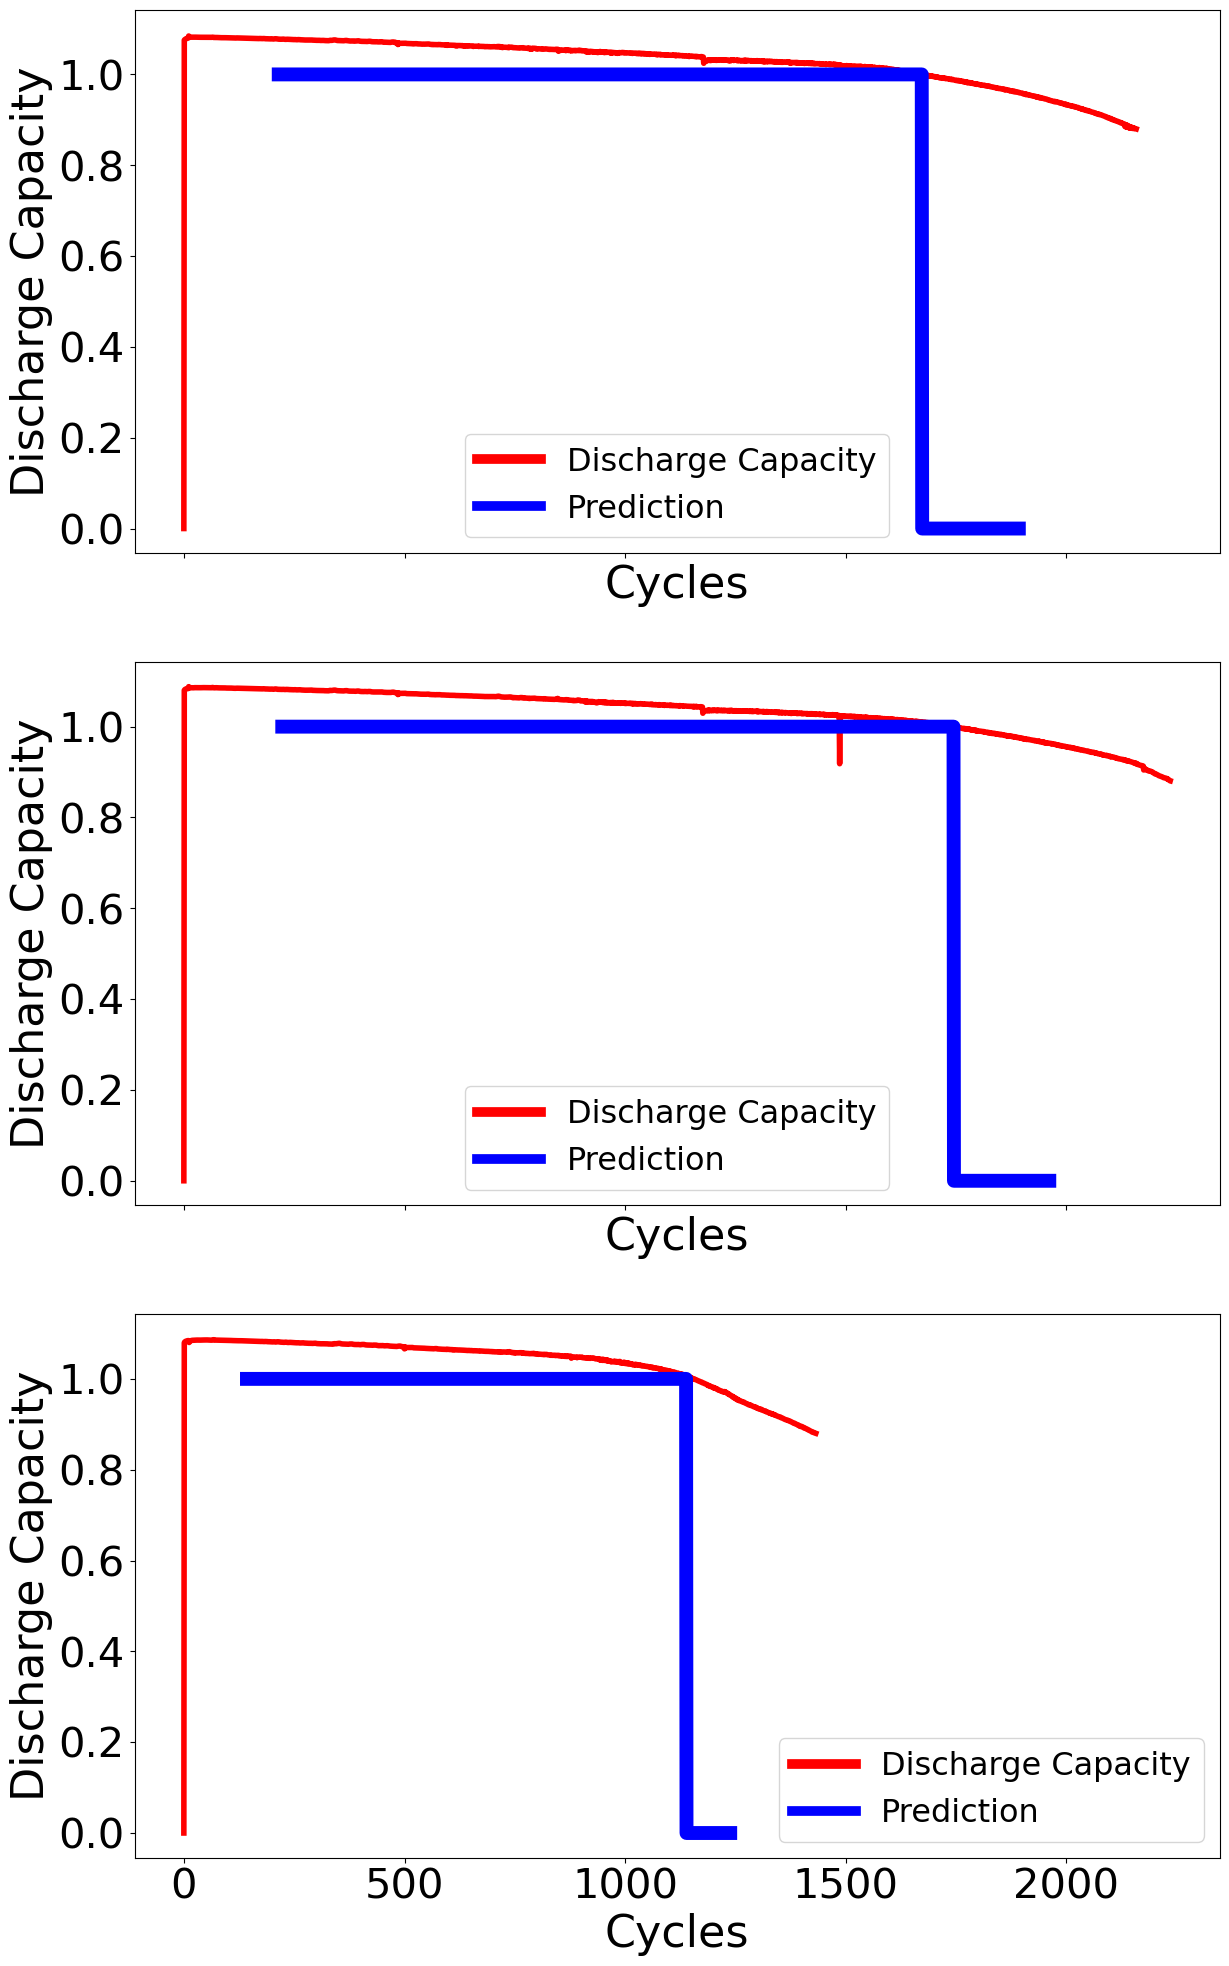

In [7]:
# batteries = [i for i in range(1,4)]
# train_data_MIT,FPC_data_MIT,FPC_data_dict_MIT = get_data(discharge_capacities_MIT[0:name_start_test_MIT],percentage,window_size,stride,channels_MIT,type = "train", name_start=name_start_train_MIT)
# _,_,_ = get_fpc_modified(model_MIT,batteries,discharge_capacities_MIT,FPC_data_dict_MIT,True, True,True,"Outputs/FPC_Training_MIT")

<Figure size 640x480 with 0 Axes>

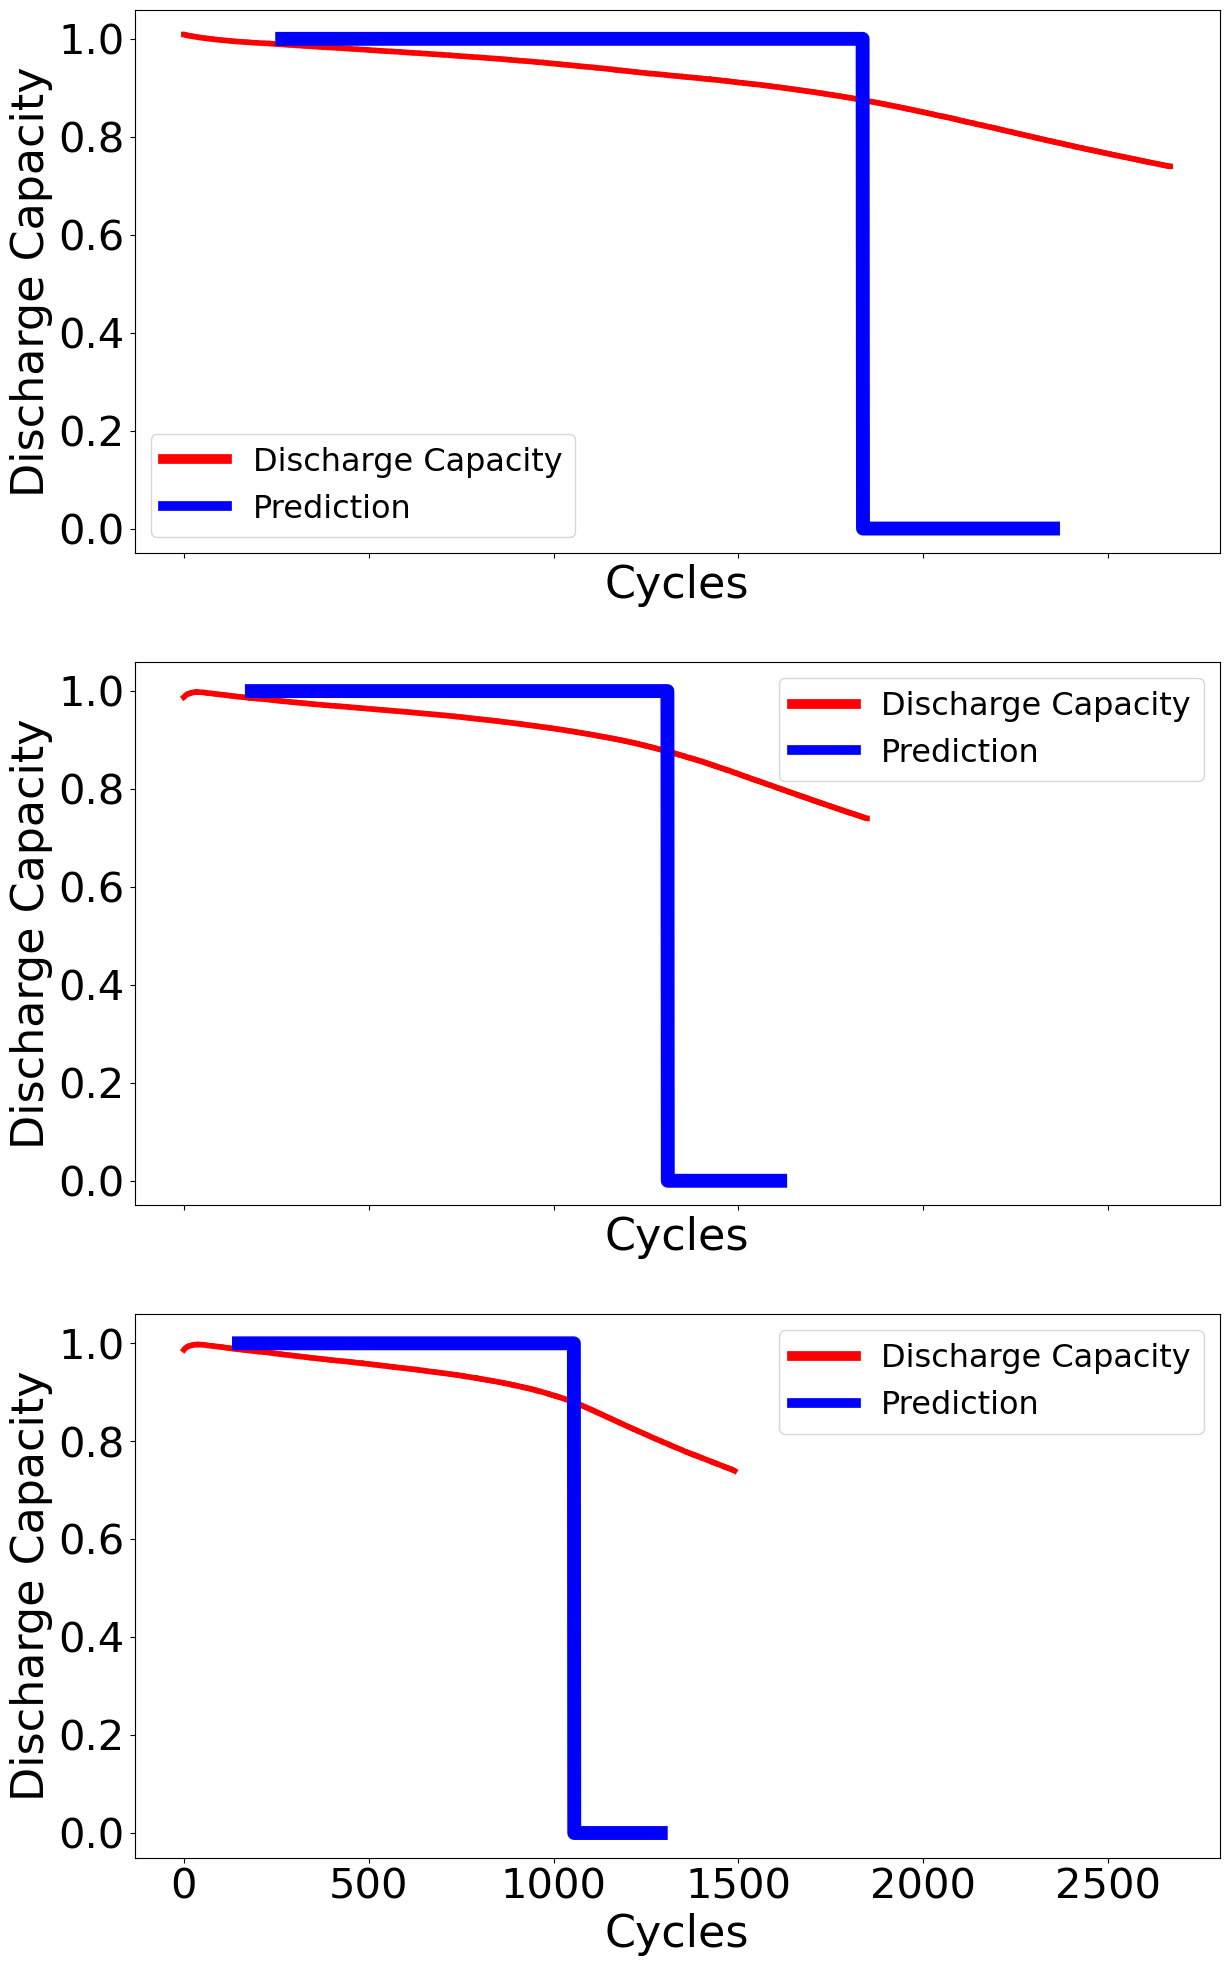

In [8]:
# batteries = [i for i in range(1,4)]
# train_data_HUST,FPC_data_HUST,FPC_data_dict_HUST = get_data(discharge_capacities_HUST[0:name_start_test_HUST],percentage,window_size,stride,channels_HUST,type = "train", name_start=name_start_train_HUST)
# _,_,_ = get_fpc_modified(model_HUST,batteries,discharge_capacities_HUST,FPC_data_dict_HUST,True, True,True,"Outputs/FPC_Training_HUST")

In [2]:
NET_MSE = (0.0008608140270252784+0.0008416815411972931 +0.0010524416685976498 +0.0008259947301983412 +0.001358155277557671)/5
NET_MAE = (0.022767719527780315+0.021711965949050175 + 0.025766627564147552 + 0.021348107753492187+0.028723010793328285)/5
NET_MAPE = (0.053543777966811375+0.05403765016667534+0.05791842134738228 +0.046695637597101824+0.06482824683189392)/5

print(NET_MSE,NET_MAE,NET_MAPE)

0.0009878174489152468 0.024063486317559703 0.05540474678197295


In [2]:
LSTM_MSE = (  0.0009408332357340872+0.0006784575461425375+0.0009206573629001396 +0.0006557163573053105 +0.00136813975404948)/5
LSTM_MAE = (0.019869665541015304+0.018640972132264632 + 0.023344863278710094 + 0.017092285292717564+0.027729760855436325)/5
LSTM_MAPE = (0.04355164139167785 +0.0482582735627953+0.056857881282791393 +0.0391021496940239+0.0605710931122303)/5

print(LSTM_MSE,LSTM_MAE,LSTM_MAE)

0.0009127608512263109 0.02133550942002878 0.02133550942002878
